#  Решение задачи регрессии при помощи пакета `torch`. Метрики.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://github.com/Lightning-AI/torchmetrics
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://pytorch-lightning.readthedocs.io/en/2.1.2/pytorch/ecosystem/metrics.html#torchmetrics

## Задачи для совместного разбора

In [ ]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

1\. Используя реализацию из `torch.nn`, решите задачу регрессии. Для расчета градиентов воспользуйтесь возможностями по автоматическому дифференцированию `torch`. В качестве функции потерь используйте собственную реализацию MSE. Для настройки весов реализуйте пакетный градиентный спуск с использованием `torch.optim.SGD`.

In [ ]:
from sklearn.datasets import make_regression
import torch.nn as nn
import torch.optim as optim
import numpy as np

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)


class MyMSELoss(nn.Module):
    def __init__(self):
        super(MyMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        return ((y_pred - y_true) ** 2).mean()

model = nn.Linear(in_features=4, out_features=1)

criterion = MyMSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 200
for epoch in range(epochs):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 40 == 0:
        print(f"Эпоха [{epoch+1}/{epochs}], Ошибка: {loss.item():.4f}")

print("Истинные значения:")
print(f"  Коэффициенты: {np.round(coef, 2)}")
print(f"  Bias: {0.5}")

print("Значения, полученные моделью:")
estimated_coefs = model.weight.data.numpy().flatten()
estimated_bias = model.bias.data.numpy()[0]

print(f"  Оцененные коэффициенты: {np.round(estimated_coefs, 2)}")
print(f"  Оцененный bias: {estimated_bias:.4f}")



Эпоха [40/200], Ошибка: 2082.8835
Эпоха [80/200], Ошибка: 465.4447
Эпоха [120/200], Ошибка: 110.3935
Эпоха [160/200], Ошибка: 27.6397
Эпоха [200/200], Ошибка: 7.2407
Истинные значения:
  Коэффициенты: [ 5.64 86.47 27.34 41.48]
  Bias: 0.5
Значения, полученные моделью:
  Оцененные коэффициенты: [ 5.4  84.6  27.54 39.23]
  Оцененный bias: 0.7730


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn` решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Для создания модели опишите класс `SineModel`.

Предлагаемая архитектура нейронной сети:
1. Полносвязный слой с 100 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).

Выведите график изменения значения функции потерь в процессе обучения. Логику расчета значения функции потерь на уровне эпохи реализуйте самостоятельно.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn
from torchtyping import TensorType

class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_out)

    def forward(self, x: TensorType["batch", "n_features"]) -> TensorType["batch", 1]:
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


Эпоха 100/400, Средняя ошибка: 0.074649
Эпоха 200/400, Средняя ошибка: 0.022013
Эпоха 300/400, Средняя ошибка: 0.018532
Эпоха 400/400, Средняя ошибка: 0.003639


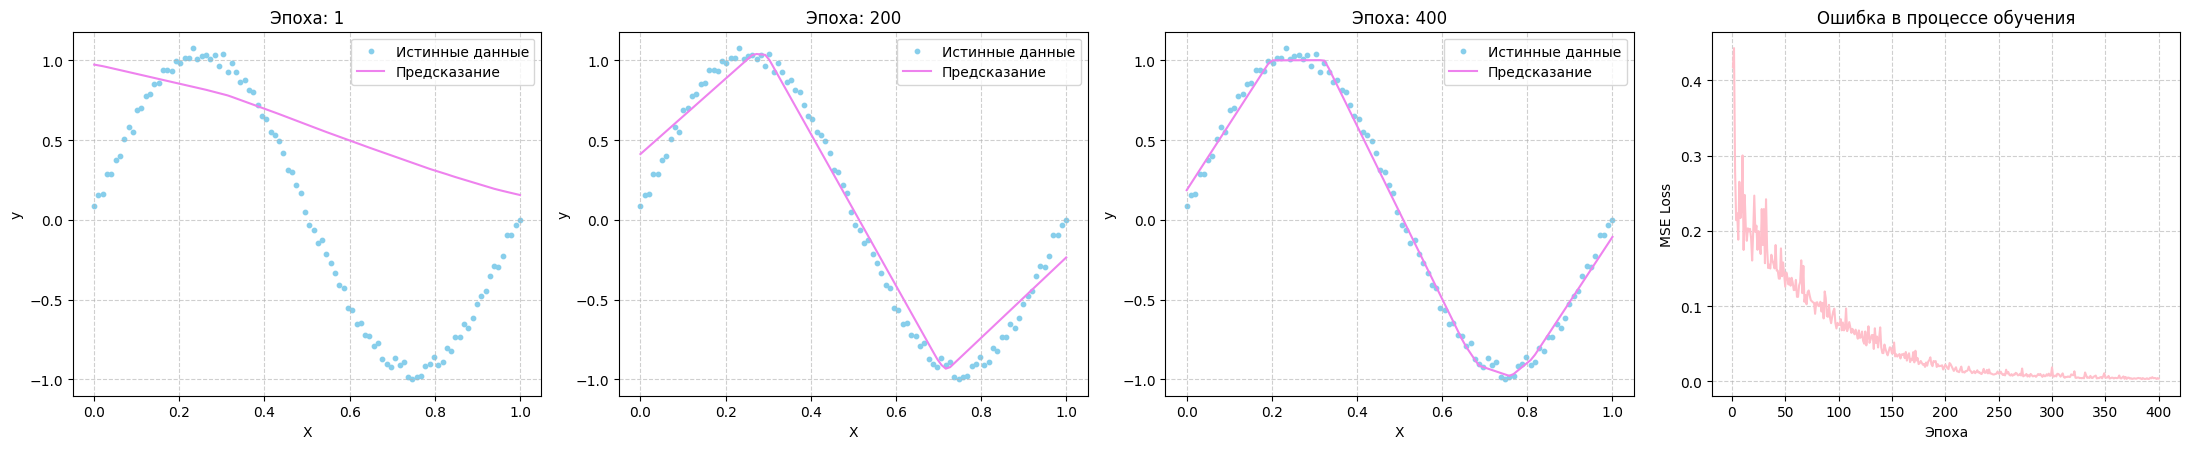

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchtyping import TensorType

torch.manual_seed(42)
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


model = SineModel(n_features=1, n_hidden=100, n_out=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

epochs = 400
epoch_losses = []
predictions_history = {}
snapshot_epochs = [1, 200, 400]

for epoch in range(1, epochs + 1):
    current_epoch_loss = 0.0
    num_batches = 0

    for inputs_batch, targets_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(inputs_batch)
        loss = criterion(y_pred, targets_batch)
        loss.backward()
        optimizer.step()

        current_epoch_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = current_epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)

    if epoch in snapshot_epochs:
        with torch.no_grad():
            full_pred = model(X)
            predictions_history[epoch] = full_pred.clone()

    if epoch % 100 == 0:
        print(f'Эпоха {epoch}/{epochs}, Средняя ошибка: {avg_epoch_loss:.6f}')


fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, epoch in enumerate(snapshot_epochs):
    ax = axes[i]
    ax.scatter(X.numpy(), y.numpy(), s=10,color='skyblue', label='Истинные данные')
    ax.plot(X.numpy(), predictions_history[epoch].numpy(), color='violet', label='Предсказание')
    ax.set_title(f'Эпоха: {epoch}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

ax_loss = axes[3]
ax_loss.plot(range(1, epochs + 1), epoch_losses, color='pink')
ax_loss.set_title('Ошибка в процессе обучения')
ax_loss.set_xlabel('Эпоха')
ax_loss.set_ylabel('MSE Loss')
ax_loss.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



<p class="task" id="2"></p>

2\. Повторите решение задачи 1, изменив модель. Для создания модели создайте объект класса `nn.Sequential`.

Предлагаемая архитектура нейронной сети:
1. Полносвязный слой с 50 нейронами
2. Активация Tanh
3. Полносвязный слой с 1 нейроном

- [ ] Проверено на семинаре

In [ ]:
import torch

X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

Эпоха 100/400, Ошибка: 0.197081
Эпоха 200/400, Ошибка: 0.196849
Эпоха 300/400, Ошибка: 0.196608
Эпоха 400/400, Ошибка: 0.196357


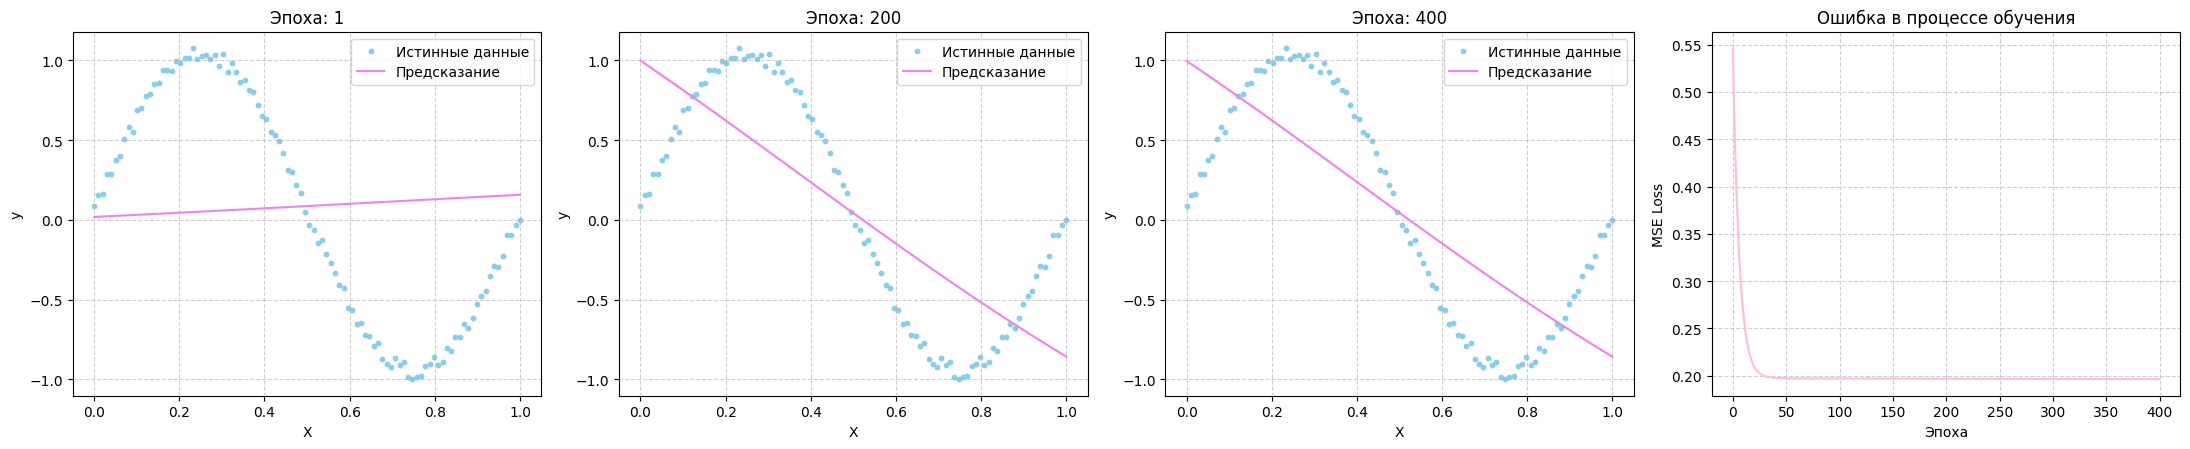

In [ ]:
torch.manual_seed(42)
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

model = nn.Sequential(
    nn.Linear(in_features=1, out_features=50),
    nn.Tanh(),
    nn.Linear(in_features=50, out_features=1)
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

epochs = 400
epoch_losses = []
predictions_history = {}
snapshot_epochs = [1, 200, 400]

for epoch in range(1, epochs + 1):
    y_pred = model(X)

    loss = criterion(y_pred, y)
    epoch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch in snapshot_epochs:
        predictions_history[epoch] = y_pred.detach().clone()

    if epoch % 100 == 0:
        print(f'Эпоха {epoch}/{epochs}, Ошибка: {loss.item():.6f}')


fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, epoch in enumerate(snapshot_epochs):
    ax = axes[i]
    ax.scatter(X.numpy(), y.numpy(), s=10,color='skyblue', label='Истинные данные')
    ax.plot(X.numpy(), predictions_history[epoch].numpy(), color='violet', label='Предсказание')
    ax.set_title(f'Эпоха: {epoch}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

ax_loss = axes[3]
ax_loss.plot(range(epochs), epoch_losses, color='pink')
ax_loss.set_title('Ошибка в процессе обучения')
ax_loss.set_xlabel('Эпоха')
ax_loss.set_ylabel('MSE Loss')
ax_loss.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<p class="task" id="3"></p>

3\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Перенесите вычисления на GPU и сравните время обучения с и без использования GPU. Решение должно корректно работать в случае отсутствия GPU без дополнительных изменений в коде.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.datasets import make_regression
import torch as th

X, y, coef = make_regression(
    n_samples=10000,
    n_features=10,
    n_informative=6,
    coef=True,
    bias=0.5,
    random_state=42
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_regression
import time
import numpy as np

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np, coef = make_regression(
    n_samples=10000,
    n_features=10,
    n_informative=6,
    coef=True,
    bias=0.5,
    random_state=42
)

X_tensor = torch.FloatTensor(X_np)
y_tensor = torch.FloatTensor(y_np).reshape(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = nn.Linear(in_features=10, out_features=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

start_time = time.time()
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0.0
    for inputs_batch, targets_batch in dataloader:
        inputs_batch = inputs_batch.to(device)
        targets_batch = targets_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(inputs_batch)
        loss = criterion(y_pred, targets_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Эпоха {epoch+1}/{epochs}, Средняя ошибка: {epoch_loss/len(dataloader):.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"время обучения: {total_time:.4f} секунд")

Используется устройство: cpu
Эпоха 1/10, Средняя ошибка: 16614.6659
Эпоха 2/10, Средняя ошибка: 12034.5344
Эпоха 3/10, Средняя ошибка: 8671.9044
Эпоха 4/10, Средняя ошибка: 6311.4784
Эпоха 5/10, Средняя ошибка: 4598.7136
Эпоха 6/10, Средняя ошибка: 3322.5974
Эпоха 7/10, Средняя ошибка: 2400.8498
Эпоха 8/10, Средняя ошибка: 1749.5843
Эпоха 9/10, Средняя ошибка: 1266.9137
Эпоха 10/10, Средняя ошибка: 925.2744
время обучения: 1.1967 секунд


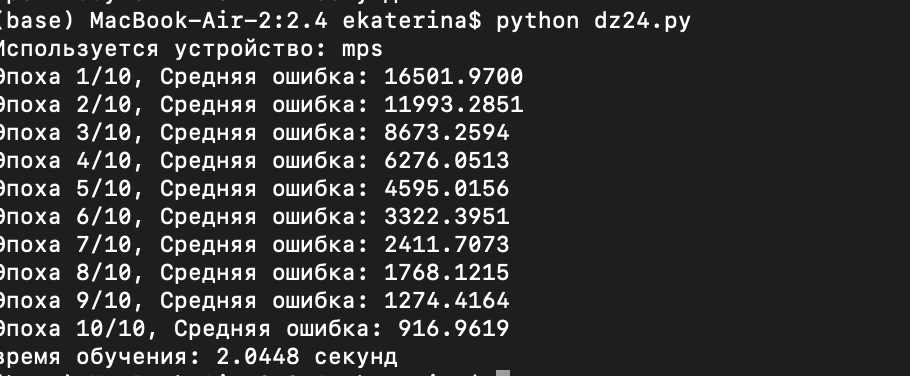

<p class="task" id="4"></p>

4\. Повторите решение задач 1-2, используя для расчета значения функции потерь за эпоху метрику `MeanMetric` из пакета `torchmetrics`. Добавьте в цикл обучения расчет метрики $R^2$ (воспользуйтесь реализацией из `torchmetrics`). Выведите на экран график изменения значения функции потерь и метрики $R^2$ по эпохам в процессе обучения.

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.1 MB/s eta 0:00:00


Используется устройство: cpu
Эпоха 1/10 -> MSE: 16619.4629, R²: 0.1412
Эпоха 2/10 -> MSE: 12029.9805, R²: 0.3784
Эпоха 3/10 -> MSE: 8673.2607, R²: 0.5500
Эпоха 4/10 -> MSE: 6265.6240, R²: 0.6736
Эпоха 5/10 -> MSE: 4572.3657, R²: 0.7629
Эпоха 6/10 -> MSE: 3311.3865, R²: 0.8281
Эпоха 7/10 -> MSE: 2397.8235, R²: 0.8752
Эпоха 8/10 -> MSE: 1750.8865, R²: 0.9093
Эпоха 9/10 -> MSE: 1274.0730, R²: 0.9342
Эпоха 10/10 -> MSE: 922.9276, R²: 0.9523
Общее время обучения: 1.4154 секунд


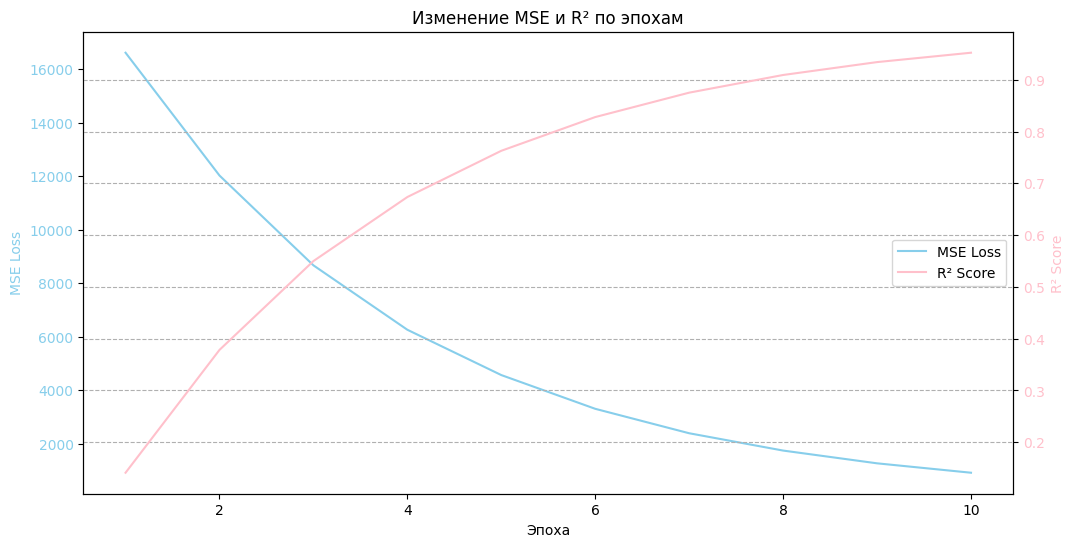

In [ ]:
import torchmetrics

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np, coef = make_regression(
    n_samples=10000,
    n_features=10,
    n_informative=6,
    coef=True,
    bias=0.5,
    random_state=42
)
X_tensor = torch.FloatTensor(X_np)
y_tensor = torch.FloatTensor(y_np).reshape(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


model = nn.Linear(in_features=10, out_features=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

loss_metric = torchmetrics.MeanMetric().to(device)
r2_metric = torchmetrics.R2Score().to(device)

start_time = time.time()

epochs = 10
epoch_losses = []
epoch_r2_scores = []

for epoch in range(epochs):
    loss_metric.reset()
    r2_metric.reset()

    for inputs_batch, targets_batch in dataloader:
        inputs_batch = inputs_batch.to(device)
        targets_batch = targets_batch.to(device)

        y_pred = model(inputs_batch)
        loss = criterion(y_pred, targets_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_metric.update(loss.detach())
        r2_metric.update(y_pred.detach(), targets_batch)

    avg_epoch_loss = loss_metric.compute()
    epoch_r2 = r2_metric.compute()

    epoch_losses.append(avg_epoch_loss.cpu().item())
    epoch_r2_scores.append(epoch_r2.cpu().item())

    print(f"Эпоха {epoch+1}/{epochs} -> MSE: {avg_epoch_loss:.4f}, R²: {epoch_r2:.4f}")

end_time = time.time()
print(f"Общее время обучения: {end_time - start_time:.4f} секунд")

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
line1 = ax1.plot(range(1, epochs + 1), epoch_losses, color='skyblue', label='MSE Loss')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('MSE Loss', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
line2 = ax2.plot(range(1, epochs + 1), epoch_r2_scores, color='pink', label='R² Score')
ax2.set_ylabel('R² Score', color='pink')
ax2.tick_params(axis='y', labelcolor='pink')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')
plt.title('Изменение MSE и R² по эпохам')
plt.grid(True, linestyle='--')
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задач 1-2, изменив функцию потерь. Обучите модель, используя три функции потерь: `MSELoss`, `L1Loss` и `HuberLoss` - и выведите на одном графике динамику изменения метрики $R^2$ по эпохам для каждой модели в процессе обучения. Добавьте подписи полученных кривых.

- [ ] Проверено на семинаре

Используется устройство: cpu
--- Эпоха 1/10 ---
  Модель с MSELoss: R² = 0.9598
  Модель с L1Loss: R² = 0.0327
  Модель с HuberLoss: R² = 0.0367
--- Эпоха 2/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.1036
  Модель с HuberLoss: R² = 0.1076
--- Эпоха 3/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.1717
  Модель с HuberLoss: R² = 0.1754
--- Эпоха 4/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.2371
  Модель с HuberLoss: R² = 0.2406
--- Эпоха 5/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.2997
  Модель с HuberLoss: R² = 0.3033
--- Эпоха 6/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.3601
  Модель с HuberLoss: R² = 0.3631
--- Эпоха 7/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.4172
  Модель с HuberLoss: R² = 0.4206
--- Эпоха 8/10 ---
  Модель с MSELoss: R² = 1.0000
  Модель с L1Loss: R² = 0.4720
  Модель с HuberLoss: R² = 0.4747
--- Эпоха 9/10 ---
  Модель с MSELoss: R² =

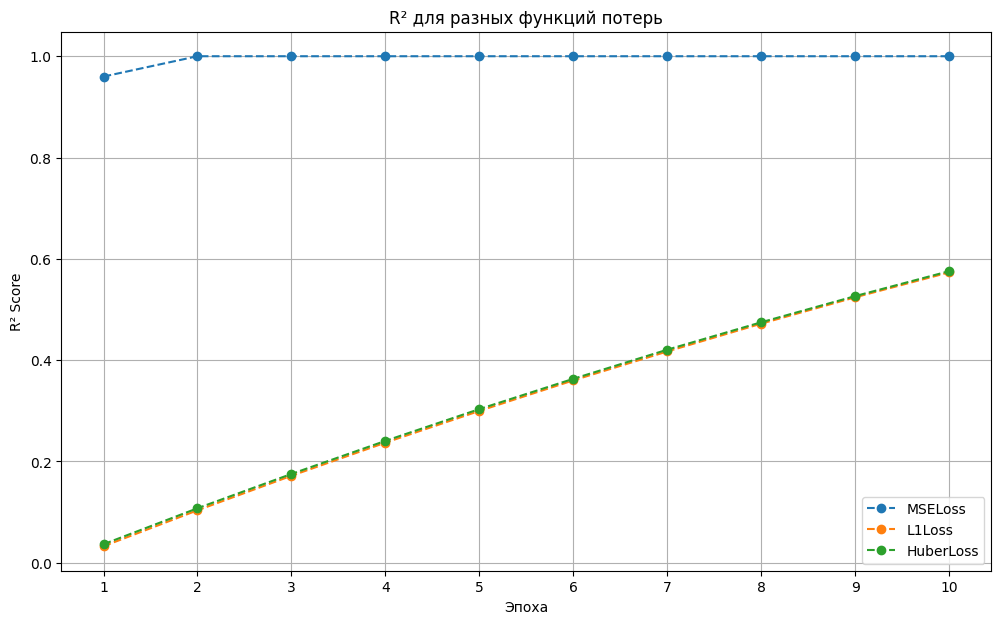

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np, _ = make_regression(
    n_samples=10000, n_features=10, n_informative=6, coef=True, bias=0.5, random_state=42
)
dataset = TensorDataset(torch.FloatTensor(X_np), torch.FloatTensor(y_np).reshape(-1, 1))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

loss_functions = {
    'MSELoss': nn.MSELoss(),
    'L1Loss': nn.L1Loss(),
    'HuberLoss': nn.HuberLoss()
}

models = {name: nn.Linear(10, 1).to(device) for name in loss_functions.keys()}
optimizers = {name: optim.SGD(model.parameters(), lr=0.01) for name, model in models.items()}
r2_metric = torchmetrics.R2Score().to(device)

start_time = time.time()
epochs = 10
r2_history = {name: [] for name in loss_functions.keys()}
for epoch in range(1, epochs + 1):
    print(f"--- Эпоха {epoch}/{epochs} ---")
    for name, model in models.items():
        loss_fn = loss_functions[name]
        optimizer = optimizers[name]

        r2_metric.reset()

        for inputs_batch, targets_batch in dataloader:
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)

            y_pred = model(inputs_batch)
            loss = loss_fn(y_pred, targets_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            r2_metric.update(y_pred.detach(), targets_batch)

        epoch_r2 = r2_metric.compute().cpu().item()
        r2_history[name].append(epoch_r2)
        print(f"  Модель с {name}: R² = {epoch_r2:.4f}")

end_time = time.time()
print(f"Общее время обучения: {end_time - start_time:.4f} секунд")

plt.figure(figsize=(12, 7))

for name, scores in r2_history.items():
    plt.plot(range(1, epochs + 1), scores, marker='o', linestyle='--', label=name)

plt.title('R² для разных функций потерь')
plt.xlabel('Эпоха')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.xticks(range(1, epochs + 1))
plt.show()



<p class="task" id="6"></p>

6\. Повторите решение задач 1-2, разделив датасет на обучающую и тестовую выборку в соотношении 80% на 20%. Обучите модель. Для тестовой выборки посчитайте и выведите на экран значения метрик:

- MAE;
- MAPE;
- MSE;
- MSLE (MeanSquaredLogError).


- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import random_split

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np, coef = make_regression(
    n_samples=10000, n_features=10, n_informative=6, coef=True, bias=0.5, random_state=42
)
dataset = TensorDataset(torch.FloatTensor(X_np), torch.FloatTensor(y_np).reshape(-1, 1))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

model = nn.Linear(in_features=10, out_features=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

start_time = time.time()
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    for inputs_batch, targets_batch in train_loader:
        inputs_batch = inputs_batch.to(device)
        targets_batch = targets_batch.to(device)

        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)
        loss.backward()
        optimizer.step()

end_time = time.time()

mae_metric = torchmetrics.MeanAbsoluteError().to(device)
mape_metric = torchmetrics.MeanAbsolutePercentageError().to(device)
mse_metric = torchmetrics.MeanSquaredError().to(device)
msle_metric = torchmetrics.MeanSquaredLogError().to(device)

model.eval()
with torch.no_grad():
    for inputs_batch, targets_batch in test_loader:
        inputs_batch = inputs_batch.to(device)
        targets_batch = targets_batch.to(device)

        y_pred = model(inputs_batch)

        mae_metric.update(y_pred, targets_batch)
        mape_metric.update(y_pred, targets_batch)
        mse_metric.update(y_pred, targets_batch)
        msle_metric.update(y_pred, targets_batch)

print(f"  MAE на тесте:  {mae_metric.compute().item():.4f}")
print(f"  MAPE на тесте: {mape_metric.compute().item():.4f}")
print(f"  MSE на тесте:  {mse_metric.compute().item():.4f}")
print(f"  MSLE на тесте: {msle_metric.compute().item():.4f}")
print(f"Общее время обучения: {end_time - start_time:.4f} секунд")


Используется устройство: cpu
Размер обучающей выборки: 8000
Размер тестовой выборки: 2000
  MAE на тесте:  0.5054
  MAPE на тесте: 0.0088
  MSE на тесте:  0.4002
  MSLE на тесте: nan
Общее время обучения: 2.8893 секунд


 MSLE на тесте: nan - в данных есть отрицательные значения